# Natural Language Processing: Feature and Model Selection 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generating text corpus

We will generate three types of words: noise, classA and classB. Each type will have a probability distribution. Each word in each type will also have a probability distribution. We will start with 50 words of each type. 

Let's start out trying a few ideas. To begin with, this function creates "random words" with a (slightly modified) normal distribution.

In [2]:
# random word generator
def random_normal_word(mean,std,name):
    number = np.random.normal(mean,std)
    number = np.abs(number).astype('int64')
    word = name + str(number)
    return word

In [3]:
# example
random_normal_word(4000,1000,'noise')

'noise3568'

In [4]:
# function to return index of random variable
# based on probability
def proba_to_index(proba,proba_list):
    index = 0
    cum_proba = np.cumsum(proba_list)
    for i in range(len(cum_proba)):
        if proba < cum_proba[i]:
            index = i
            break
    return index

In [5]:
def generate_text(percents,min_len,max_len):
    '''
    percents is a list with the percentage of each type in the text.
    percents[0] => 'classA'
    percents[1] => 'classB'
    percents[2] => 'noise'
    '''
    classes = ['classA','classB','noise']
    length = np.random.randint(min_len,max_len)
    text = ''
    for i in range(length):
        class_proba = np.random.random()
        index = proba_to_index(class_proba,percents)
        name = classes[index]
        word = random_normal_word(4000,1000,name)
        text += word + ' '
    return text

In [6]:
example = generate_text([0.3,0.1,0.6],500,1000)
example[0:500]

'noise5364 noise5128 classB3520 noise993 noise3057 classA3590 classA3098 noise5258 classA4310 noise4245 classA4859 noise2780 noise3158 classB3587 classA5632 noise5637 noise4899 classA4865 noise5390 noise3495 noise3016 classA7349 classA4595 noise3203 classB5748 noise4154 classB2234 noise4518 classA3846 noise3776 noise5055 noise1901 noise3893 classB4819 noise2961 noise4650 noise4505 noise2295 noise3923 classA4122 noise880 noise2943 classA2425 noise6376 noise4656 noise3408 noise4217 noise4443 noise5'

In [7]:
# sanity check
count_noise,count_A, count_B = 0,0,0
for word in example.split():
    if word.startswith('noise'):
        count_noise += 1
    elif word.startswith('classA'):
        count_A += 1
    else:
        count_B += 1
print(f'Total words\nNoise: {count_noise}\nClass A: {count_A}\nClass B: {count_B}')

Total words
Noise: 568
Class A: 288
Class B: 93


We are ready to generate our corpus. We will construct 1000 samples of between 500 and 1000 words each.

In [8]:
# Let's say classes are split 60/40
random_list = np.random.random(2000)
target_list = []
for r in random_list:
    if r < 0.6:
        target_list.append(1)
    else:
        target_list.append(0)

len(target_list)

2000

In [9]:
df = pd.DataFrame()
df['target'] = target_list
df.head()

,target
0,0
1,0
2,0
3,1
4,1


In [10]:
# create text for each instance
# class A = 0, class B = 1
df['text'] = ''
df['text'].astype('object')
for i in df.index:
    if df.at[i,'target'] == 1:
        text = generate_text([0.1,0.3,0.6],500,1000)
        df.at[i,'text'] = text
    else:
        text = generate_text([0.3,0.1,0.6],500,1000)
        df.at[i,'text'] = text

In [11]:
df.head()

,target,text
0,0,noise4846 noise2988 classA4337 noise2720 noise...
1,0,noise3385 noise2478 noise4008 noise5023 noise3...
2,0,classB1868 classB5729 noise3252 classB4127 noi...
3,1,noise3191 classA3144 noise5437 noise3545 class...
4,1,classB2565 noise5036 noise6097 noise2380 noise...


In [12]:
# class A instances
dfA = df[df.target == 0]
# proportion
dfA.shape[0] / df.shape[0]

0.3985

In [13]:
# sanity check: class A percentage of words
# in class A instances
count_total = 0
count_A = 0
for i in dfA.index:
    text = dfA.at[i,'text']
    count_total += len(text.split())
    for w in text.split():
        if w.startswith('classA'):
            count_A += 1
print(f'Proporcion: {count_A / count_total}')

Proporcion: 0.299242990933844


## Tf-idf demonstration

In [14]:
# df creation
df_trial = pd.DataFrame()
df_trial['target'] = [0,0,0,1,1,0]
df_trial

,target
0,0
1,0
2,0
3,1
4,1
5,0


In [15]:
# adding text column with made up words
df_trial.at[0,'text'] = 'a1 a1 b1 a1 c1 z1'
df_trial.at[1,'text'] = 'b1 a1 b1 b1 c1 c1'
df_trial.at[2,'text'] = 'b1 a1 b1 a1 c1 c1'
df_trial.at[3,'text'] = 'b1 a1 x1 z1'
df_trial.at[4,'text'] = 'a1'
df_trial.at[5,'text'] = 'a1 z1'
df_trial

,target,text
0,0,a1 a1 b1 a1 c1 z1
1,0,b1 a1 b1 b1 c1 c1
2,0,b1 a1 b1 a1 c1 c1
3,1,b1 a1 x1 z1
4,1,a1
5,0,a1 z1


### Sci-kit learn

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True)
fit_vectorizer = vectorizer.fit(df_trial.text)
tfidf_trial = fit_vectorizer.transform(df_trial.text)

In [17]:
tfidf_trial.shape

(6, 5)

In [18]:
# list of words in corpus
fit_vectorizer.get_feature_names()

['a1', 'b1', 'c1', 'x1', 'z1']

In [19]:
# dictionary matching word to matrix column
fit_vectorizer.vocabulary_

{'a1': 0, 'b1': 1, 'c1': 2, 'z1': 4, 'x1': 3}

In [20]:
# dense matrix representation
tfidf_trial.todense()

matrix([[0.75831693, 0.33782317, 0.39422769, 0.        , 0.39422769],
        [0.19314873, 0.77441376, 0.60247563, 0.        , 0.        ],
        [0.43774852, 0.58503874, 0.6827195 , 0.        , 0.        ],
        [0.31168683, 0.4165608 , 0.        , 0.70215656, 0.48611171],
        [1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.53976033, 0.        , 0.        , 0.        , 0.84181874]])

In [21]:
# array representation
trial_arr = tfidf_trial.toarray()
trial_arr

array([[0.75831693, 0.33782317, 0.39422769, 0.        , 0.39422769],
       [0.19314873, 0.77441376, 0.60247563, 0.        , 0.        ],
       [0.43774852, 0.58503874, 0.6827195 , 0.        , 0.        ],
       [0.31168683, 0.4165608 , 0.        , 0.70215656, 0.48611171],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.53976033, 0.        , 0.        , 0.        , 0.84181874]])

In [22]:
# apply function to each column
np.apply_along_axis(np.sum,0,trial_arr)

array([3.24066135, 2.11383648, 1.67942281, 0.70215656, 1.72215813])

The above function gives us the sum of tf-idf values for each column. We will use it later for mean tf-idf.

In [23]:
# sparse representation
print(tfidf_trial)

  (0, 4)	0.39422768553293636
  (0, 2)	0.39422768553293636
  (0, 1)	0.3378231745907559
  (0, 0)	0.7583169302001058
  (1, 2)	0.6024756322681024
  (1, 1)	0.7744137645910423
  (1, 0)	0.19314873474884586
  (2, 2)	0.6827194968035845
  (2, 1)	0.5850387383458417
  (2, 0)	0.4377485160671207
  (3, 4)	0.4861117058129096
  (3, 3)	0.70215655540208
  (3, 1)	0.4165607989744412
  (3, 0)	0.3116868331118981
  (4, 0)	1.0
  (5, 4)	0.8418187357325301
  (5, 0)	0.5397603321564903


In [24]:
# choose specific word columns
# say I want to choose columns for 'b1' and 'z1'
words = ['b1','z1']
columns = []
for w in words:
    column = fit_vectorizer.vocabulary_[w]
    columns.append(column)
columns

[1, 4]

In [25]:
filt_arr = trial_arr[:,columns]
filt_arr

array([[0.33782317, 0.39422769],
       [0.77441376, 0.        ],
       [0.58503874, 0.        ],
       [0.4165608 , 0.48611171],
       [0.        , 0.        ],
       [0.        , 0.84181874]])

Notice that there are methods that belong to <b>the vectorizer</b> (vocabulary,get_feature_names()) and there are methods that belong to <b>the matrix</b> (todense(),toarray()). 

## Word Frequency in our corpus

In [26]:
bag = []
bag_neg = []
bag_pos = []
for i in df.index:
    word_list = df.text[i].split()
    bag.extend(word_list)
    if df.target[i] == 1:
        bag_pos.extend(word_list)
    else:
        bag_neg.extend(word_list)
print(f'Total words: {len(bag)}')
if len(bag) - len(bag_pos) - len(bag_neg) == 0:
    print('Sum of words OK')
else:
    print('Please check')

Total words: 1510633
Sum of words OK


In [27]:
import nltk
freq_bag = nltk.FreqDist(bag)
freq_df = pd.DataFrame(list(freq_bag.items()), columns = ["Word","TotFreq"])
freq_df.head()

,Word,TotFreq
0,noise4846,274
1,noise2988,234
2,classA4337,112
3,noise2720,159
4,noise3676,333


In [28]:
print(f'Total words: {freq_df.shape[0]}')

Total words: 20141


## Tf-idf vectorization in our corpus

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
fit_df_vectorizer = vectorizer.fit(df.text)
tfidf_df = fit_df_vectorizer.transform(df.text)

In [30]:
# vectorizer for each class
A_vectorizer = TfidfVectorizer(lowercase=False)
fit_A_vectorizer = A_vectorizer.fit(df.text)
df_A = df[df.target == 0]
tfidf_A = fit_A_vectorizer.transform(df_A.text)

B_vectorizer = TfidfVectorizer(lowercase=False)
fit_B_vectorizer = B_vectorizer.fit(df.text)
df_B = df[df.target == 1]
tfidf_B = fit_B_vectorizer.transform(df_B.text)

In [31]:
# create array of tf-idf mean value 
# for each df and for each word
total_means = np.apply_along_axis(np.mean,0,
                                  tfidf_df.toarray())
A_means = np.apply_along_axis(np.mean,0,
                                  tfidf_A.toarray())
B_means = np.apply_along_axis(np.mean,0,
                                  tfidf_B.toarray())

In [32]:
A_means[0:10]

array([8.16000251e-05, 2.36049994e-04, 0.00000000e+00, 1.71443093e-04,
       8.23748181e-05, 1.04700527e-04, 0.00000000e+00, 1.67159103e-04,
       9.40573780e-05, 9.76020702e-05])

In [33]:
B_means[0:10]

array([1.61773290e-04, 0.00000000e+00, 5.24817646e-05, 4.82026654e-05,
       0.00000000e+00, 0.00000000e+00, 5.40796997e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [34]:
# list of words and indices
df_words = fit_df_vectorizer.get_feature_names()
df_indices = fit_df_vectorizer.vocabulary_
A_words = fit_A_vectorizer.get_feature_names()
A_indices = fit_A_vectorizer.vocabulary_
B_words = fit_B_vectorizer.get_feature_names()
B_indices = fit_B_vectorizer.vocabulary_

In [35]:
# add tf-idf values for each word to word df
for i in freq_df.index:
    word = freq_df.at[i,'Word']
    col_index = df_indices[word]
    freq_df.at[i,'tf-idf'] = total_means[col_index]
    if word in A_words:
        col_A_index = A_indices[word]
        freq_df.at[i,'tf-idf_A'] = A_means[col_A_index]
    if word in B_words:
        col_B_index = B_indices[word]
        freq_df.at[i,'tf-idf_B'] = B_means[col_B_index]

freq_df.head()

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B
0,noise4846,274,0.003854,0.004239,0.003599
1,noise2988,234,0.003467,0.003674,0.003331
2,classA4337,112,0.002042,0.003636,0.000986
3,noise2720,159,0.002639,0.003539,0.002042
4,noise3676,333,0.004445,0.004011,0.004733


In [36]:
# normalized difference for ease of display
freq_df['diff'] = (freq_df['tf-idf_A'] - freq_df['tf-idf_B'])*10000
freq_df['abs_diff'] = abs(freq_df['diff'])
freq_df = freq_df.sort_values(by='abs_diff',ascending=False)
freq_df.head(7)

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff
5861,classB4094,166,0.002761,0.000658,0.004154,-34.962605,34.962605
1354,classA4010,126,0.002247,0.004302,0.000885,34.167655,34.167655
3884,classA3943,111,0.001994,0.003975,0.000681,32.942679,32.942679
4668,classA4035,111,0.002007,0.003987,0.000696,32.912014,32.912014
9615,classA4447,100,0.001843,0.003776,0.000561,32.150898,32.150898
2951,classA4144,126,0.002223,0.004155,0.000942,32.124249,32.124249
4876,classA3994,110,0.002001,0.003901,0.000741,31.594224,31.594224


In [37]:
freq_df.tail(7)

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff
13131,classB1270,5,0.000164,0.000164,0.000164,-0.002563,0.002563
17641,classB6435,5,0.000173,0.000173,0.000172,0.002237,0.002237
18622,classB6816,5,0.000150,0.000150,0.000150,-0.002198,0.002198
5228,noise5950,63,0.001307,0.001307,0.001307,0.001811,0.001811
9584,noise1697,23,0.000562,0.000562,0.000562,0.000610,0.000610
17663,classA6703,5,0.000146,0.000146,0.000146,-0.000305,0.000305
9405,noise2658,141,0.002410,0.002410,0.002410,-0.000128,0.000128


We can see the pattern here: the words with more (absolute) tf-idf difference for the two classes are the most frequent words of the most frequent class. That is, the word number is near the mean of the underlying normal distribution (which was if 4000 you recall) and the class is the most prevalent one (A). On the other hand, the least difference belongs to words that are noise or unfrequent words. 

(In the following section we study a slightly different strategy, that will give A and B words a similar importance, and leave noise words further behind). 

Let's plot it.

In [38]:
# word class to compare
for i in freq_df.index:
    word = freq_df.at[i,'Word']
    if word.startswith('noise'):
        freq_df.at[i,'class'] = 'noise'
    elif word.startswith('classA'):
        freq_df.at[i,'class'] = 'A'
    else:
        freq_df.at[i,'class'] = 'B'

In [39]:
freq_df.head()

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff,class
5861,classB4094,166,0.002761,0.000658,0.004154,-34.962605,34.962605,B
1354,classA4010,126,0.002247,0.004302,0.000885,34.167655,34.167655,A
3884,classA3943,111,0.001994,0.003975,0.000681,32.942679,32.942679,A
4668,classA4035,111,0.002007,0.003987,0.000696,32.912014,32.912014,A
9615,classA4447,100,0.001843,0.003776,0.000561,32.150898,32.150898,A


In [40]:
freq_A = freq_df[freq_df['class'] == 'A']
freq_A = freq_A.sort_values(by='abs_diff',ascending=False).head(7)
freq_noise = freq_df[freq_df['class'] == 'noise']
freq_noise = freq_noise.sort_values(by='abs_diff',ascending=False).head(7)
freq_B = freq_df[freq_df['class'] == 'B']
freq_B = freq_B.sort_values(by='abs_diff',ascending=False).head(7)

In [41]:
freq_A

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff,class
1354,classA4010,126,0.002247,0.004302,0.000885,34.167655,34.167655,A
3884,classA3943,111,0.001994,0.003975,0.000681,32.942679,32.942679,A
4668,classA4035,111,0.002007,0.003987,0.000696,32.912014,32.912014,A
9615,classA4447,100,0.001843,0.003776,0.000561,32.150898,32.150898,A
2951,classA4144,126,0.002223,0.004155,0.000942,32.124249,32.124249,A
4876,classA3994,110,0.002001,0.003901,0.000741,31.594224,31.594224,A
2117,classA3808,113,0.002048,0.003931,0.000800,31.306618,31.306618,A


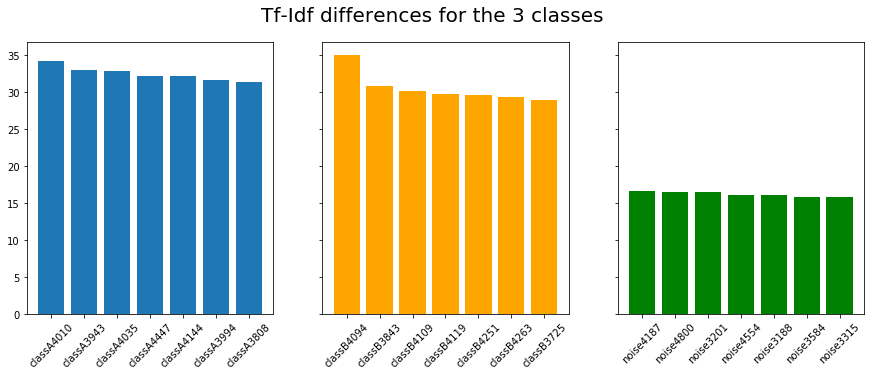

In [42]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].bar(freq_A.Word,freq_A.abs_diff)
ax[0].set_xticklabels(freq_A.Word, rotation=45)
ax[1].bar(freq_B.Word,freq_B.abs_diff,color='orange')
ax[1].set_xticklabels(freq_B.Word, rotation=45)
ax[2].bar(freq_noise.Word,freq_noise.abs_diff,color='green')
ax[2].set_xticklabels(freq_noise.Word, rotation=45)
plt.suptitle('Tf-Idf differences for the 3 classes',size=20)
plt.show()

## Functions for generalizing this tasks

In [43]:
def df_to_bag(df_X):
    '''
    Takes df_X (string), return bag of words
    (in df format)
    Requires NLTK
    '''
    bag = []
    for i in df_X.index:
        word_list = df_X[i].split()
        bag.extend(word_list)
    freq_bag = nltk.FreqDist(bag)
    bag_df = pd.DataFrame(list(freq_bag.items()), columns = ["Word","TotFreq"])
    return bag_df

In [44]:
func_bag = df_to_bag(df.text)
func_bag.head()

,Word,TotFreq
0,noise4846,274
1,noise2988,234
2,classA4337,112
3,noise2720,159
4,noise3676,333


In [45]:
def df_to_tfidf(df,text_col,target,fit='cat'):
    '''
    Takes as input a df and the name of the target column.
    Returns a list with information about each category:
    category name, tf-idf matrix, tf-idf mean for each word
    Requires pandas,sklearn TdidfVectorizer
    fit parameter: if 'df', tf-idf Vectorizer fit on whole df.
    if 'cat', fit in each category
    '''
    tfidf_list = []
    X = df[text_col]
    y = df[target]
    vectorizer = TfidfVectorizer(lowercase=False)
    df_vecto = vectorizer.fit(X)
    fit_vecto = df_vecto.transform(X)
    means_arr = np.apply_along_axis(np.mean,0,
                                  fit_vecto.toarray())
    tfidf_list.append(['df',df_vecto,fit_vecto,means_arr])
    for i in y.unique():
        vect_aux = TfidfVectorizer(lowercase=False)
        if fit == 'cat':
            df_aux = df[df[target] == i]
            X_aux = df_aux[text_col]
            vect_aux_transf = vect_aux.fit_transform(X_aux)
        elif fit == 'df':
            vect_aux_fit = vect_aux.fit(X)
            df_aux = df[df[target] == i]
            X_aux = df_aux[text_col]
            vect_aux_transf = vect_aux.transform(X_aux)
        means_arr = np.apply_along_axis(np.mean,0,
                                  vect_aux_transf.toarray())
        tfidf_list.append([i,vect_aux,
                           vect_aux_transf,means_arr])
    return tfidf_list

In [46]:
func_tfidf = df_to_tfidf(df,'text','target')
func_tfidf[0]

['df', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None), <2000x20141 sparse matrix of type '<class 'numpy.float64'>'
 	with 1437211 stored elements in Compressed Sparse Row format>, array([1.29824244e-04, 9.40659224e-05, 3.15677814e-05, ...,
        1.56479680e-04, 2.11580728e-04, 1.59635918e-04])]

In [47]:
def tfidf_cat(bag_df,tfidf_list):
    '''
    Takes a bag of words df extracted from a
    dataset, its corresponding tf-idf list 
    (containing category names, tf-idf object, 
    tf-idf mean values for each category and word)
    Returns a df with tf-idf values and differences
    for each word.
    bag_df must have a 'Word' column
    '''
    df_words = tfidf_list[0][1].get_feature_names()
    df_indices = tfidf_list[0][1].vocabulary_
    for i in bag_df.index:
        # assign tf-idf values to each word (total)
        word = bag_df.at[i,'Word']
        col_index = df_indices[word]
        df_means = tfidf_list[0][3]
        bag_df.at[i,'tf-idf'] = df_means[col_index]
        # assign tf-idf values to each word (each category)
        for j in range(1,len(tfidf_list)):
            cat_words = tfidf_list[j][1].get_feature_names()
            cat_name = tfidf_list[j][0]
            if word not in cat_words:
                bag_df.at[i,'tf-idf_'+str(cat_name)] = 0
            else:
                cat_indices = tfidf_list[j][1].vocabulary_
                col_index = cat_indices[word]
                cat_means = tfidf_list[j][3]
                bag_df.at[i,'tf-idf_'+str(cat_name)] = cat_means[col_index]
    return bag_df

In [48]:
func_df = tfidf_cat(func_bag,func_tfidf)
func_df.head()

,Word,TotFreq,tf-idf,tf-idf_0,tf-idf_1
0,noise4846,274,0.003854,0.004205,0.003726
1,noise2988,234,0.003467,0.003698,0.003415
2,classA4337,112,0.002042,0.003190,0.001176
3,noise2720,159,0.002639,0.003351,0.002201
4,noise3676,333,0.004445,0.004211,0.004721


In [49]:
def col_diff(df,col0,col1):
    df['diff'] = (df[col0] - df[col1])*10000
    df['abs_diff'] = np.abs(df['diff'])
    df = df.sort_values(by='abs_diff',ascending=False)
    return df

In [50]:
func_df = col_diff(func_df,'tf-idf_1','tf-idf_0')
func_df.head()

,Word,TotFreq,tf-idf,tf-idf_0,tf-idf_1,diff,abs_diff
5861,classB4094,166,0.002761,0.000931,0.003726,27.950963,27.950963
1354,classA4010,126,0.002247,0.003661,0.001114,-25.473224,25.473224
3884,classA3943,111,0.001994,0.003378,0.000864,-25.148575,25.148575
4668,classA4035,111,0.002007,0.003381,0.000888,-24.932443,24.932443
5894,classB3843,159,0.002632,0.001043,0.003500,24.575677,24.575677


In [51]:
# values to plot
func_freq_A = func_df[func_df['Word'].apply(lambda x: x.startswith('classA'))]
func_freq_A = func_freq_A.sort_values(by='abs_diff',ascending=False).head(7)
func_freq_noise = func_df[func_df['Word'].apply(lambda x: x.startswith('noise'))]
func_freq_noise = func_freq_noise.sort_values(by='abs_diff',ascending=False).head(7)
func_freq_B = func_df[func_df['Word'].apply(lambda x: x.startswith('classB'))]
func_freq_B = func_freq_B.sort_values(by='abs_diff',ascending=False).head(7)

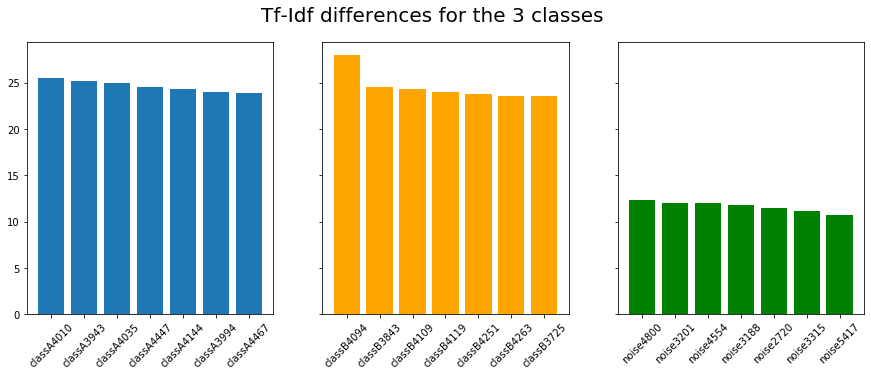

In [52]:
# plots
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].bar(func_freq_A.Word,func_freq_A.abs_diff)
ax[0].set_xticklabels(func_freq_A.Word, rotation=45)
ax[1].bar(func_freq_B.Word,func_freq_B.abs_diff,color='orange')
ax[1].set_xticklabels(freq_B.Word, rotation=45)
ax[2].bar(func_freq_noise.Word,func_freq_noise.abs_diff,color='green')
ax[2].set_xticklabels(func_freq_noise.Word, rotation=45)
plt.suptitle('Tf-Idf differences for the 3 classes',size=20)
plt.show()

Notice the difference between this plot and the previous one. The difference is in the way the tf-idf matrix is fit and transformed. In the previous section version, we fit the vectorizer to the whole dataframe (tf-idf values are calculated from the full bag of words); in this one, we fit it to a dataframe filtered by each category. We will study the performance of each in the next section.

In [53]:
# wrapping function
def df_to_freq_df(df,target='target',text_col='text',
                 fit='cat'):
    bag_df = df_to_bag(df[text_col])
    tfidf_list = df_to_tfidf(df,text_col=text_col,
                            target=target,fit=fit)
    bag_df = tfidf_cat(bag_df,tfidf_list)
    target0 = str(df[target].unique()[0])
    target1 = str(df[target].unique()[1])
    col0 = 'tf-idf_'+target0
    col1 = 'tf-idf_'+target1
    freq_df = col_diff(bag_df,col0,
                       col1)
    return (freq_df,tfidf_list)

In [54]:
wrap_df = df_to_freq_df(df)
wrap_df[0].head(10)

,Word,TotFreq,tf-idf,tf-idf_0,tf-idf_1,diff,abs_diff
5861,classB4094,166,0.002761,0.000931,0.003726,-27.950963,27.950963
1354,classA4010,126,0.002247,0.003661,0.001114,25.473224,25.473224
3884,classA3943,111,0.001994,0.003378,0.000864,25.148575,25.148575
4668,classA4035,111,0.002007,0.003381,0.000888,24.932443,24.932443
5894,classB3843,159,0.002632,0.001043,0.003500,-24.575677,24.575677
9615,classA4447,100,0.001843,0.003185,0.000729,24.560193,24.560193
5454,classB4109,150,0.002517,0.000944,0.003376,-24.320110,24.320110
2951,classA4144,126,0.002223,0.003583,0.001155,24.282218,24.282218
2125,classB4263,133,0.002311,0.000753,0.003151,-23.976572,23.976572
4876,classA3994,110,0.002001,0.003331,0.000934,23.969971,23.969971


In [55]:
wrap2_df = df_to_freq_df(df,fit='df')
wrap2_df[0].head(10)

,Word,TotFreq,tf-idf,tf-idf_0,tf-idf_1,diff,abs_diff
5861,classB4094,166,0.002761,0.000658,0.004154,-34.962605,34.962605
1354,classA4010,126,0.002247,0.004302,0.000885,34.167655,34.167655
3884,classA3943,111,0.001994,0.003975,0.000681,32.942679,32.942679
4668,classA4035,111,0.002007,0.003987,0.000696,32.912014,32.912014
9615,classA4447,100,0.001843,0.003776,0.000561,32.150898,32.150898
2951,classA4144,126,0.002223,0.004155,0.000942,32.124249,32.124249
4876,classA3994,110,0.002001,0.003901,0.000741,31.594224,31.594224
2117,classA3808,113,0.002048,0.003931,0.000800,31.306618,31.306618
3477,classA3925,120,0.002134,0.004017,0.000887,31.300514,31.300514
649,classA4467,101,0.001893,0.003769,0.000649,31.196478,31.196478


## Other Univariate Feature Selection Strategies

### Comparison Metric

To compare between the different strategies, we will use the following metric: the mean of the (ordered) indices corresponding to noise variables in the ranking. The higher this metric, the more the strategy separates noise from structure. We will start by calculating this metric for our tf-idf dataframes.

In [57]:
wrap_df_ord = wrap_df[0].reset_index(drop=True)
tfidf_cat_ranks = []
for i in wrap_df_ord.index:
    word = wrap_df_ord.at[i,'Word']
    if word.startswith('noise'):
        tfidf_cat_ranks.append(i)

print(f'First indices: {tfidf_cat_ranks[0:10]}')
print(f'Mean: {np.mean(tfidf_cat_ranks)}')
print(f'Median: {np.median(tfidf_cat_ranks)}')

First indices: [3396, 3589, 3590, 3712, 3862, 4013, 4276, 4306, 4319, 4368]
Mean: 13568.425303389595
Median: 13597.0


In [58]:
wrap2_df_ord = wrap2_df[0].reset_index(drop=True)
tfidf_df_ranks = []
for i in wrap2_df_ord.index:
    word = wrap2_df_ord.at[i,'Word']
    if word.startswith('noise'):
        tfidf_df_ranks.append(i)

print(f'First indices: {tfidf_df_ranks[0:10]}')
print(f'Mean: {np.mean(tfidf_df_ranks)}')
print(f'Median: {np.median(tfidf_df_ranks)}')

First indices: [2936, 3002, 3003, 3175, 3186, 3255, 3262, 3633, 3649, 4001]
Mean: 13352.088017854652
Median: 13324.0


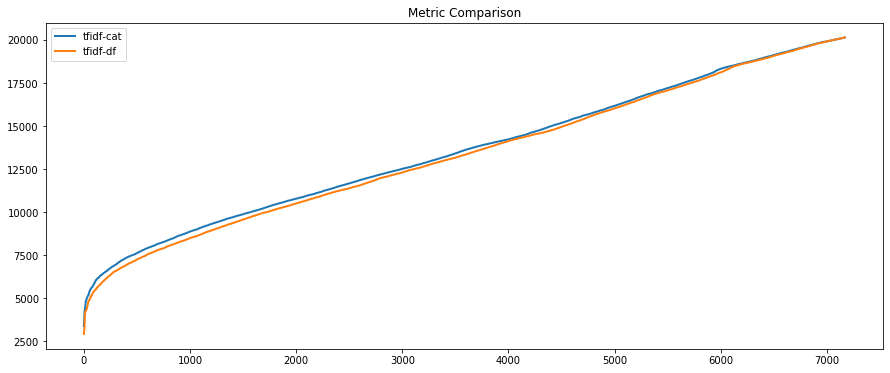

In [59]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-df')
plt.legend()
plt.title('Metric Comparison')
plt.show()

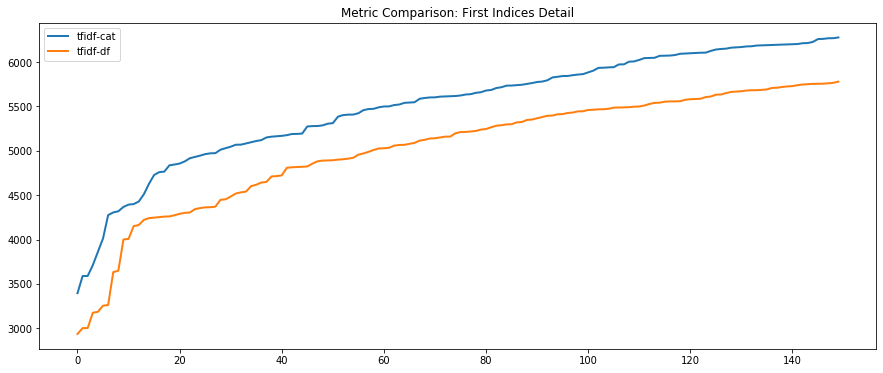

In [60]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks[0:150]
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks[0:150]
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-df')
plt.legend()
plt.title('Metric Comparison: First Indices Detail')
plt.show()

We can see that the first strategy (fit='cat') selects relevant features better. 

### Mutual Information with Count Vectorizer

In [61]:
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_extraction.text import CountVectorizer

In [62]:
df_reset = df.reset_index(drop=True)
df_reset.head()

,target,text
0,0,noise4846 noise2988 classA4337 noise2720 noise...
1,0,noise3385 noise2478 noise4008 noise5023 noise3...
2,0,classB1868 classB5729 noise3252 classB4127 noi...
3,1,noise3191 classA3144 noise5437 noise3545 class...
4,1,classB2565 noise5036 noise6097 noise2380 noise...


In [63]:
cv = CountVectorizer(lowercase=False)
count_mat = cv.fit_transform(df_reset.text)

In [64]:
count_mat.shape

(2000, 20141)

In [65]:
df_reset.at[0,'text'][0:500]

'noise4846 noise2988 classA4337 noise2720 noise3676 noise4132 noise2570 noise4773 noise4460 noise3598 noise3853 noise3743 noise5951 classA3437 noise4479 noise5979 noise4681 classA5758 noise3687 noise3702 noise2311 noise3875 classA5418 noise2801 classB5481 noise3702 noise4347 noise5604 noise4345 noise2122 noise3215 noise4567 noise4696 noise4658 classA3226 noise4745 noise4771 classA5184 noise2855 noise3531 classA3818 noise4034 classA4581 noise3229 noise4369 classA4548 noise1155 noise5643 noise3112 '

In [69]:
# let's check the result
# create a dictionary with word count for first instance
df_mi = pd.DataFrame()
string = df_reset.at[0,'text']
word_count = {}
for w in string.split():
    if w in word_count.keys():
        word_count[w] += 1
    else:
        word_count[w] = 1

In [70]:
# check the results with my fit_transform matrix
for w in word_count.keys():
    col = cv.vocabulary_[w]
    cv_value = count_mat.toarray()[0,col]
    my_value = word_count[w]
    if cv_value != my_value:
        print(f'Error in word {w}')
else:
    print('Check OK!')

Check OK!


In [71]:
mi_count = mutual_info_classif(count_mat,df_reset.target)
mi_count

array([9.80310702e-05, 1.38177274e-03, 2.54247222e-04, ...,
       1.27289681e-03, 9.72522350e-05, 1.17579870e-08])

In [72]:
mi_count.shape

(20141,)

In [73]:
# create df for this classifier
mi_count_df = pd.DataFrame()
word_list = cv.get_feature_names()
for i,w in enumerate(word_list):
    mi_count_df.at[i,'Word'] = w
    index = cv.vocabulary_[w]
    mi_count_df.at[i,'mi'] = mi_count[index]

In [74]:
mi_count_df.head()

,Word,mi
0,classA1000,0.000098
1,classA1003,0.001382
2,classA1004,0.000254
3,classA1005,0.000220
4,classA1006,0.000460


In [75]:
mi_count_df = mi_count_df.sort_values(by='mi',ascending=False)
mi_count_df = mi_count_df.reset_index(drop=True)
mi_count_df.head()

,Word,mi
0,classB4094,0.019394
1,classA4447,0.019139
2,classA4035,0.018570
3,classA4010,0.018068
4,classA3943,0.017962


In [76]:
mi_count_ranks = []
for i in mi_count_df.index:
    word = mi_count_df.at[i,'Word']
    if word.startswith('noise'):
        mi_count_ranks.append(i)

In [77]:
print(f'First indices: {mi_count_ranks[0:10]}')
print(f'Mean: {np.mean(mi_count_ranks)}')
print(f'Median: {np.median(mi_count_ranks)}')

First indices: [3859, 4085, 4110, 4321, 4838, 5071, 5084, 5127, 5187, 5188]
Mean: 13954.79299762868
Median: 14223.0


### Mutual Information with Tf-idf 

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(lowercase=False)
tf_mat = tf.fit_transform(df_reset.text)

In [79]:
mi_tf = mutual_info_classif(tf_mat,df.target)
mi_tf

array([0.0012227 , 0.00138177, 0.00025425, ..., 0.0012729 , 0.0021912 ,
       0.00168254])

In [80]:
# create df for this classifier
mi_tf_df = pd.DataFrame()
word_list = cv.get_feature_names()

for i,w in enumerate(word_list):
    mi_tf_df.at[i,'Word'] = w
    index = cv.vocabulary_[w]
    mi_tf_df.at[i,'mi'] = mi_tf[index]
    
mi_tf_df = mi_tf_df.sort_values(by='mi',ascending=False)
mi_tf_df = mi_tf_df.reset_index(drop=True)

In [81]:
mi_tf_ranks = []
for i in mi_tf_df.index:
    word = mi_tf_df.at[i,'Word']
    if word.startswith('noise'):
        mi_tf_ranks.append(i)

In [82]:
print(f'First indices: {mi_tf_ranks[0:10]}')
print(f'Mean: {np.mean(mi_tf_ranks)}')
print(f'Median: {np.median(mi_tf_ranks)}')

First indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Mean: 8217.861486957734
Median: 7611.0


In [83]:
mi_tf_df.head(10)

,Word,mi
0,noise4058,0.123115
1,noise3726,0.122365
2,noise3940,0.122274
3,noise3824,0.121838
4,noise3846,0.121718
5,noise4089,0.121516
6,noise4054,0.121491
7,noise4208,0.121352
8,noise3954,0.121264
9,noise4200,0.121041


### Chi2

In [84]:
from sklearn.feature_selection import chi2
chi_count = chi2(count_mat,df.text)
chi_count

(array([1996., 1997., 1999., ..., 1995., 1993., 1995.]),
 array([0.51472746, 0.50841568, 0.4957937 , ..., 0.52103765, 0.53364698,
        0.52103765]))

In [92]:
# create df for this classifier
chi_df = pd.DataFrame()
word_list = cv.get_feature_names()

for i,w in enumerate(word_list):
    chi_df.at[i,'Word'] = w
    index = cv.vocabulary_[w]
    chi_df.at[i,'chi-stat'] = chi_count[0][index]
    chi_df.at[i,'p-val'] = chi_count[1][index]

In [93]:
chi_df = chi_df.sort_values(by='chi-stat',ascending=False)
chi_df = chi_df.reset_index(drop=True)

In [94]:
chi_ranks = []
for i in chi_df.index:
    word = chi_df.at[i,'Word']
    if word.startswith('noise'):
        chi_ranks.append(i)

In [97]:
chi_df.head(10)

,Word,chi-stat,p-val
0,noise7421,3998.000000,7.984779e-136
1,classB1491,3330.333333,5.553946e-70
2,classA1332,2996.000000,3.514525e-43
3,classB1509,2996.000000,3.514525e-43
4,classB6473,2996.000000,3.514525e-43
5,classA1685,2996.000000,3.514525e-43
6,classA1177,2996.000000,3.514525e-43
7,classA1396,2996.000000,3.514525e-43
8,classA6365,2795.000000,1.393646e-29
9,classA5897,2734.000000,7.009843e-26


### Comparing Filtering Strategies

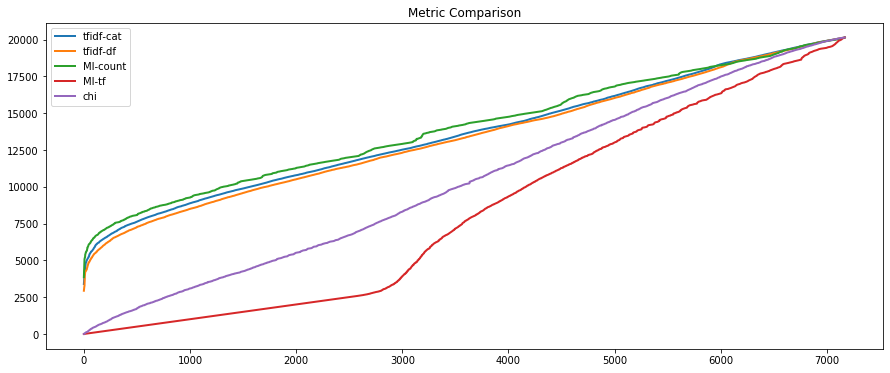

In [100]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks
plt.plot(x,y,linewidth=2,label='tfidf-df')
y = mi_count_ranks
plt.plot(x,y,linewidth=2,label='MI-count')
y = mi_tf_ranks
plt.plot(x,y,linewidth=2,label='MI-tf')
y = chi_ranks
plt.plot(x,y,linewidth=2,label='chi')
plt.legend()
plt.title('Metric Comparison')
plt.show()

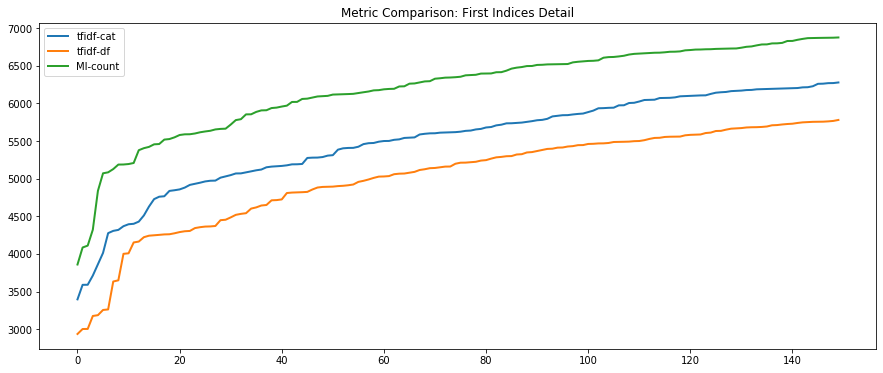

In [101]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks[0:150]
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks[0:150]
plt.plot(x,y,linewidth=2,label='tfidf-df')
y = mi_count_ranks[0:150]
plt.plot(x,y,linewidth=2,label='MI-count')
plt.legend()
plt.title('Metric Comparison: First Indices Detail')
plt.show()

## Discarded ideas

### Inefficient number generation procedure

In [ ]:
# generate random integers
probas_noise = np.random.random(50)
probas_noise = probas_noise / np.sum(probas_noise) # normalize
probas_noise = np.sort(probas_noise) # probability distribution
probas_noise = np.cumsum(probas_noise) # cumulative
probas_noise

In [ ]:
# now I need a list of words
words_noise = ['noise'+str(i) for i in range(50)] # words in this class
print(words_noise)

In [ ]:
# function to return index of random variable
# based on probability
def proba_to_index(proba,proba_list):
    index = 0
    cum_proba = np.cumsum(proba_list)
    for i in range(len(cum_proba)):
        if proba < cum_proba[i]:
            index = i
            break
    return index

In [ ]:
# function to generate random ocurrences of words
# based on an (cumulative) probability
def random_word(proba,word_list,proba_list):
    word_proba = np.random.random()
    index = 0
    index = proba_to_index(word_proba,proba_list)
    word = word_list[index]
    return word

In [ ]:
# example
random_word(np.random.random(),words_noise,probas_noise)

OK, we are good to go. Let's automate that with functions.

In [ ]:
def cum_proba(proba_list):
    probas = np.array(proba_list)
    probas = probas / np.sum(probas) # normalize
    probas = np.sort(probas) # probability distribution
    probas = np.cumsum(probas) # cumulative
    return probas

In [ ]:
def generate_proba_dist(size):
    probas = np.random.random(50)
    probas = cum_proba(probas)
    return probas

In [ ]:
def generate_word_list(size,name):
    word_list = [str(name)+str(i) for i in range(size)]
    return word_list

In [ ]:
# create class A and B words and probas
probas_classA = generate_proba_dist(50)
words_classA = generate_word_list(50,'classA')
probas_classB = generate_proba_dist(50)
words_classB = generate_word_list(50,'classB')

We have our probability distributions and our word lists in order. Now we will generate random texts, with the following criteria: noise type words will have the same probability to appear in any of the class A or class B texts. classA type words will be unlikely to appear to appear in classB texts, and likely to appear in class A texts. 

To start, we will use the following values: 60% noise words, 30% own class words, 10% other class words. The text length will also be randomized.

In [ ]:
proba_prueba = [0.6,0.3,0.1]
proba_to_index(0.95,proba_prueba)

In [ ]:
def generate_text(noise_vars,own_vars,
                  other_vars,percents,
                 min_len,max_len):
    '''
    Each argument is a tuple containing word_list([0]),
    cumulative probability distribution ([1])
    percents is a list with the percentage of each in the text
    '''
    length = np.random.randint(min_len,max_len)
    text = ''
    vars_list = [noise_vars,own_vars,other_vars]
    for i in range(length):
        class_proba = np.random.random()
        index = proba_to_index(class_proba,percents)
        word_list = vars_list[index][0]
        proba_list = vars_list[index][1]
        word_proba = np.random.random()
        word = random_word(word_proba,word_list,proba_list)
        text += word + ' '
    return text

Let's generate class A text.

In [ ]:
# variables for function
noise_vars = [words_noise,probas_noise]
classA_vars = [words_classA,probas_classA]
classB_vars = [words_classB,probas_classB]
percentsA = [0.6,0.3,0.1]
percentsA = [0.6,0.1,0.3]

In [ ]:
# example class A text
sample_text = generate_text(noise_vars,classA_vars,
                            classB_vars,percentsA,
                           500,600)
sample_text[0:1000]

In [ ]:
# let's analyze it briefly
word_list = sample_text.split()
noise_count,A_count,B_count = 0,0,0
for w in word_list:
    if w.startswith('noise'):
        noise_count += 1
    elif w.startswith('classA'):
        A_count += 1
    else:
        B_count += 1
print(f'Counts\nNoise: {noise_count}\nA: {A_count}\nB: {B_count}')